# Daily Equity Notes

Looking at simple ML approaches to daily equity data from  quandl.  

(https://www.quandl.com/data/WIKI/documentation/bulk-download)


Initial focus is on a single name model. That is, the feature space only has one equity in it at a time.

First, let's get some data & see what it looks like.

In [1]:
# imports
import pandas as pd
import numpy as np
from scipy import stats

import sklearn
from sklearn import preprocessing as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
import sys
import tensorflow as tf
import time
import os
import os.path
import pickle
import logging as log
log.basicConfig(level=log.DEBUG)


In [2]:
# obviously change this to where you downloaded file
dlfile = '~/WIKI-eod/WIKI_20161014.csv'
daily = pd.read_csv(dlfile,header=0)
log.info('Read #%d records',len(daily.index));
daily.columns = ['Sym', 'Date', 'Open','High','Low','Close',
                    'Volume','ExDiv','SplitRatio','AdjOpen',
                        'AdjHigh','AdjLow','AdjClose','AdjVolume']


INFO:root:Read #14397677 records


In [3]:
daily.head()

,Sym,Date,Open,High,Low,Close,Volume,ExDiv,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
0,A,1999-11-19,42.94,43.00,39.81,40.38,10897100,0,1,40.925976,40.983162,37.942784,38.486049,10897100
1,A,1999-11-22,41.31,44.00,40.06,44.00,4705200,0,1,39.372429,41.936259,38.181058,41.936259,4705200
2,A,1999-11-23,42.50,43.63,40.25,40.25,4274400,0,1,40.506614,41.583613,38.362146,38.362146,4274400
3,A,1999-11-24,40.13,41.94,40.00,41.06,3464400,0,1,38.247774,39.972880,38.123872,39.134155,3464400
4,A,1999-11-26,40.88,41.50,40.75,41.19,1237100,0,1,38.962597,39.553517,38.838695,39.258057,1237100


In [4]:
daily.shape

(14397677, 14)

In [5]:
# We don't care about the dividends or splits - just the adjusted values

# discard non-adjusted values, index & rename
u = daily.ix[:,[0,1,9,10,11,12,13]]
u.set_index('Date', inplace=True)
u.columns = ['Sym', 'Open','High','Low','Close','Volume']

# get rid of oldest data
u = u[u.index > '2000-01-01']

daily = None # GC, please

u.describe()

,Open,High,Low,Close,Volume
count,10369506.000000,10370177.000000,10370178.000000,10370452.000000,1.037049e+07
mean,86.409172,87.771469,85.712048,86.767500,1.525541e+06
std,2607.084731,2640.130524,2602.431868,2622.166833,6.696445e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,9.252726,9.435610,9.070000,9.251582,6.770000e+04
50%,17.720953,18.005583,17.414353,17.721023,2.843000e+05
75%,32.355495,32.830000,31.862424,32.357199,1.043200e+06
max,228180.000000,229374.000000,227530.000000,229300.000000,2.304019e+09


In [6]:
#how many names?
len(u.Sym.unique())

3182

Data is free and dirty.  Let's clean it up and get rid of low liquidity symbols.

In [7]:
# calculate daily $ volume and break into quantiles just to get an idea
addvs = u.groupby('Sym').apply( lambda x : (x.Volume * x.Close).median())
addvs.sort_values()
np.percentile(addvs, [50, 75,90] )

array([  4815869.87      ,  20137294.04770667,  71981312.14842507])

In [8]:
# let's get rid of items less than $10m/day
goners = addvs[addvs < 1e7]
u = u[ np.logical_not(u.Sym.isin(goners.index))]
#how many names?
len(u.Sym.unique())

1185

In [9]:
len(goners)

1997

So, far we've cut away at our data pretty severely: by date and liquidity, reducing the number of names from over 3182 to 1185.  We may want to swing back and use some of the discarded data for training purposes later...  

In [10]:
bysz = u.groupby('Sym').size()
bysz.head()
bysz.sort_values(inplace=True)
#bysz.quantiles([.25,.5,.75])
np.percentile(bysz,[25,50,75])

#bysz.tail()

array([ 2671.,  4209.,  4213.])

In [11]:
u.describe()

,Open,High,Low,Close,Volume
count,4016418.000000,4016435.000000,4016435.000000,4016448.000000,4.016474e+06
mean,161.238687,163.519086,160.778457,162.214876,3.498868e+06
std,4075.955728,4125.549919,4073.578097,4101.119243,1.040870e+07
min,0.014558,0.021700,0.014558,0.020500,0.000000e+00
25%,15.428015,15.682500,15.162920,15.430000,5.645000e+05
50%,26.671175,27.060000,26.270000,26.675538,1.310200e+06
75%,44.887430,45.456395,44.295812,44.896840,3.179500e+06
max,228180.000000,229374.000000,227530.000000,229300.000000,2.304019e+09


In [12]:
# let's replace zeros for nans so we can ffill them
u.replace(0,np.nan, inplace=True)
u.replace([np.inf, -np.inf], np.nan,inplace=True)
u.describe()

,Open,High,Low,Close,Volume
count,4016418.000000,4016435.000000,4016435.000000,4016448.000000,4.015687e+06
mean,161.238687,163.519086,160.778457,162.214876,3.499554e+06
std,4075.955728,4125.549919,4073.578097,4101.119243,1.040960e+07
min,0.014558,0.021700,0.014558,0.020500,1.600000e+01
25%,15.428015,15.682500,15.162920,15.430000,5.648000e+05
50%,26.671175,27.060000,26.270000,26.675538,1.310700e+06
75%,44.887430,45.456395,44.295812,44.896840,3.180100e+06
max,228180.000000,229374.000000,227530.000000,229300.000000,2.304019e+09


In [13]:
# need to examine our nans...
badz = u[u.isnull().any(axis=1)]
badz.describe()
badcount = badz.groupby('Sym').size()
np.sort(badcount)
#np.percentile(badcount,[25,50,75])


array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   3,   3,   3,   3,   4,   4,   6,
         6,   6,   6,   7,   7,   9,   9,  10,  10,  17,  18,  18,  18,
        19,  19,  20,  20,  22,  26,  26,  28,  31,  31,  35,  37,  67, 182])

In [14]:
# get rid of anyone missing more than 100 observations
goners = badcount[badcount>100].index
u = u[ np.logical_not(u.Sym.isin(goners))]
len(u.Sym.unique())

1184

The following gives us a uniform set of names that continue trading up until today
and have been trading since 2000-01-01.  This is a mixed blessing as it allows us to create a 'square' dataset with known tradable instruments but also gets rid of a lot of good data, eliminates newer names and introduces survivorship bias...

it's also slow...

all of that said, we're going to do it so we know we have a complete and tradable dataset.  We can revisit this as we get deeper into strategy development as needed.

In [15]:
Z = u.groupby('Sym').filter( lambda x: x.index.min() == u.index.min() and x.index.max() == u.index.max())
Z.shape

(2713595, 6)

Ok, we have a mostly usable dataset.  Let's calculate some moments, take a quick look at the data and see if we can run it in the simulator.

In [16]:
# let's verify that we can use z  in our sim environment
import sim 
# fill in missing data
Z = sim.squarem(Z)

# create a universe suitable for simulation
Ubig = sim.prep_univ( Z.index, Z.Sym, Z.Open, Z.High, Z.Low, Z.Close, Z.Volume, Z.Sym)
Ubig.shape

INFO:root:Got rid of 0/644 symbols


(2724764, 19)

In [17]:
Ubig.describe()

,Multiplier,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD,Fwd_Open,Fwd_COReturn
count,2724764,2724764.000000,2724764.000000,2724764.000000,2724764.000000,2.724764e+06,2.724763e+06,2724763.000000,2724763.000000,2724764.000000,2724764.000000,2724761.000000,2724764.000000,2724764.000000
mean,1,221.500822,223.113033,219.617956,221.458409,4.027689e+06,4.026459e+06,0.000170,0.000297,221.528037,0.000297,0.022109,221.569666,0.000316
std,0,4991.186437,5017.957331,4954.869489,4988.315556,1.211738e+07,1.086434e+07,0.478678,0.027592,4989.924149,0.027592,0.016716,4992.776936,0.014036
min,1,0.014558,0.078649,0.014558,0.058986,4.300000e+01,1.000000e+02,-9.486203,-3.570812,0.058986,-3.570812,0.000000,0.014558,-0.999744
25%,1,15.367480,15.611537,15.110396,15.369879,6.148695e+05,6.998400e+05,-0.277910,-0.010309,15.373677,-0.010309,0.012176,15.371148,-0.003635
50%,1,26.574552,26.946967,26.191651,26.577681,1.469000e+06,1.588625e+06,-0.011542,0.000225,26.584421,0.000225,0.017607,26.580746,0.000000
75%,1,45.038956,45.583092,44.483704,45.048963,3.604000e+06,3.718508e+06,0.261779,0.011050,45.060235,0.011050,0.026434,45.050000,0.004249
max,1,228180.000000,229374.000000,227530.000000,229300.000000,2.304019e+09,6.079510e+08,10.324815,1.449269,229300.000000,1.449269,0.812276,228180.000000,3.078370


Let's look at some of the names in the universe.  


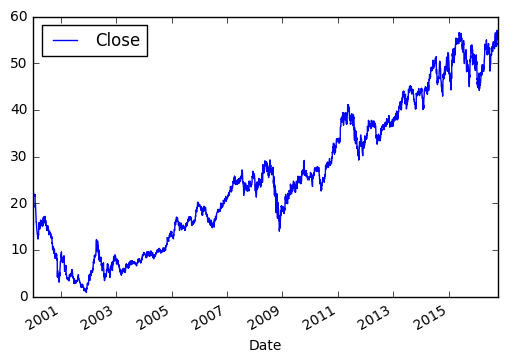

In [18]:
S = Ubig[Ubig.Sym=='CCK'].Close
type(S)
S.plot(legend=True)

#Ubig[Ubig.Sym=='AAPL'].Close.plot()
#Ubig[Ubig.Sym=='TDW'].Close.plot()
#plt.legend()

Let's run a simple hold-the-universe-in-equal-weight strategy just to see that it looks sensible-ish.

INFO:root:ran over 4231 days and 2724764 rows in 125 secs


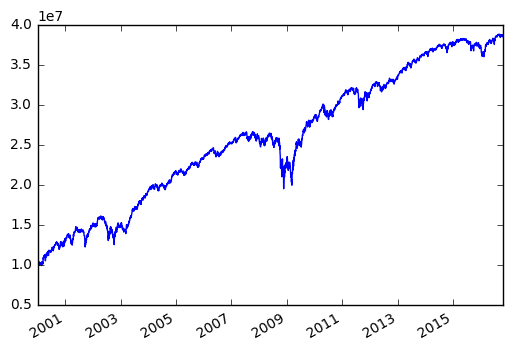

In [21]:
# run simulation, capturing balances and discarding trading activity details
# the default strategy simply buys the universe in equal weight and re-weights daily
_,B = sim.sim(Ubig)
# plot NAV
B.NAV.plot()

Apparently indexing works. Now that we've munged the data sufficiently, let's store the Universe for future use.

In [22]:
pickle.dump(Ubig, open( 'U.pkl', "wb"))
log.info('Wrote U.pkl')
len(Ubig.Sym.unique())

INFO:root:Wrote U.pkl


644

OK, let's look at a few baseline strategies before we see if we can improve any of them with ML.

Trading 600+ names a day is a pain.  Can we replicate the performance with fewer names?  

Assuming we have no edge, what would it look like to trade an equal-weighted basket of 10 RANDOM names every day?  Let's simulate 10 iterations of the strategy and see what it will look like individually and in aggregate


INFO:root:ran over 4231 days and 2724764 rows in 117 secs
INFO:root:ran over 4231 days and 2724764 rows in 117 secs
INFO:root:ran over 4231 days and 2724764 rows in 121 secs
INFO:root:ran over 4231 days and 2724764 rows in 124 secs
INFO:root:ran over 4231 days and 2724764 rows in 121 secs
INFO:root:ran over 4231 days and 2724764 rows in 111 secs
INFO:root:ran over 4231 days and 2724764 rows in 121 secs
INFO:root:ran over 4231 days and 2724764 rows in 120 secs
INFO:root:ran over 4231 days and 2724764 rows in 123 secs
INFO:root:ran over 4231 days and 2724764 rows in 125 secs


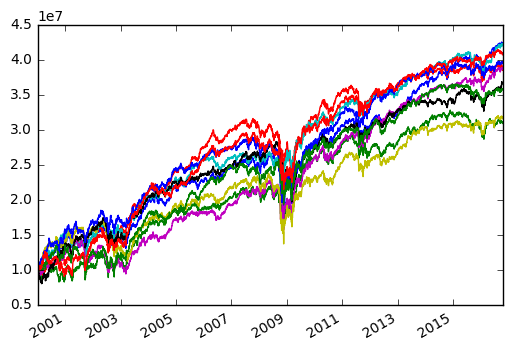

In [23]:
# this is the strategy
#def random_strat( U, cfg, kvargs ) :
    # random portfolio strategy: picks 'num_names' randomly
#    nnames = kvargs.pop('num_names',10)
#    names = random.sample(U.Sym, nnames )
#    U.Weight = np.where( U.Sym.isin( names ), 1/float(nnames), 0 )                 
#    return U

# let's run it 10 times 
N = sim.rtest(Ubig, runs=10)

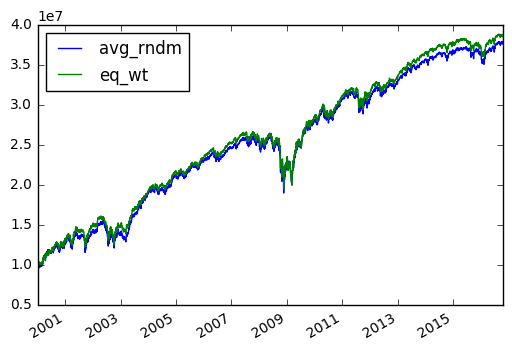

In [24]:
# looking at them both together yields a pretty neat result
nm = N.mean(1)
both = pd.DataFrame( {'eq_wt':B.NAV, 'avg_rndm': nm})
both.plot()

Makes sense, but cute anyway: any given instance of the random strategy will vary meaningfully from the index, but in aggregate they will tend toward the performance of the index.

Holding the entire market on an equal-weighted basis is a fine indexing strategy.
Holding a random 10 names on an equal-weighted basis tends to replicate its performance.

Can we find a selection criteria that improves on this for us?

Let's try some simple things.  First, a strategy that holds the prior day's 10 
biggest winners and then a strategy that holds the prior day's biggest losers.


INFO:root:ran over 4231 days and 2724764 rows in 127 secs


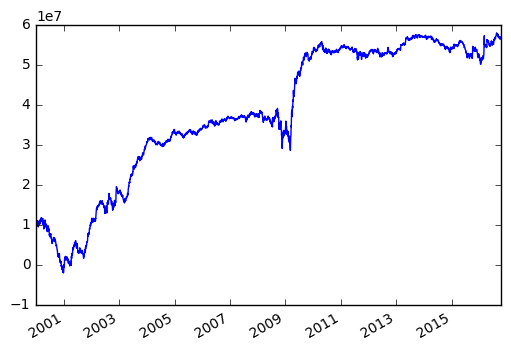

In [27]:
best_strat = sim.best_strat
_,BBB = sim.sim(Ubig,sim_FUN=best_strat)
BBB.NAV.plot()

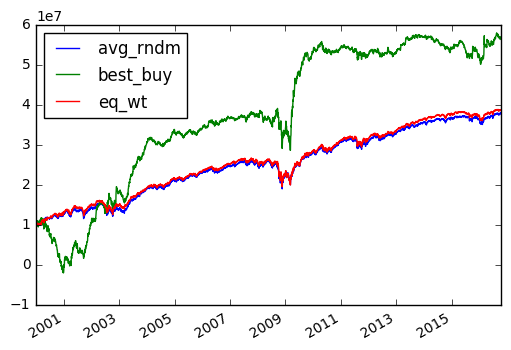

In [28]:
nm = N.mean(1)
#bb=BuyBest.mean(1)
three = pd.DataFrame( {'eq_wt':B.NAV, 'avg_rndm': nm, 'best_buy':BBB.NAV})
three.plot()

Buying winners wins big when it works but will take you on a pretty wrenching ride and would have blown you up if you traded it through 2000.

Now let's look at buying the prior day's worst names.

INFO:root:ran over 4231 days and 2724764 rows in 125 secs


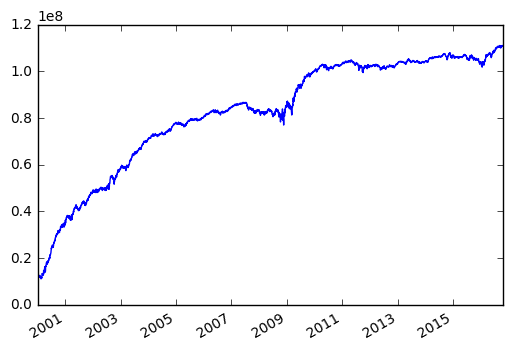

In [30]:
worst_strat = sim.worst_strat
_,BWB = sim.sim(Ubig,sim_FUN=worst_strat)
BWB.NAV.plot()

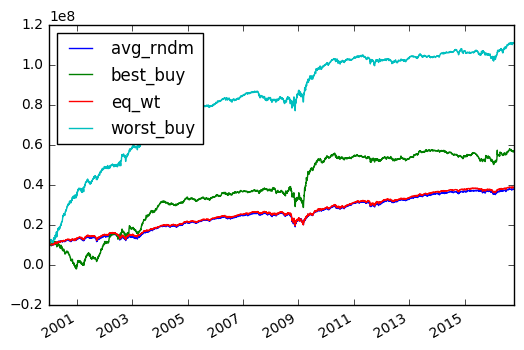

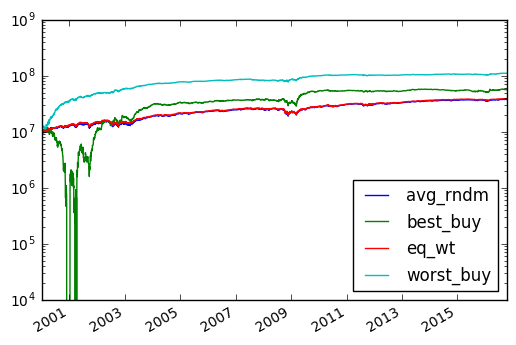

In [31]:
four = pd.DataFrame( {'eq_wt':B.NAV, 'avg_rndm': N.mean(1), 'best_buy':BBB.NAV, 'worst_buy':BWB.NAV})
four.plot()
four.plot(loglog=True)

Looks like mean reversion is a thing at these frequencies... Fair enough.

So, let's summarize our progress.

- we pulled the free equity dataset off Quandl manually...
- then munged it into a form suitable for simple simulations
- we ran some simple, portfolio-oriented daily equity strategies on the simulator

Next, we'll take a look at training ML models with this dataset and see if we can improve on any of our simple strategies...
